Downloading and Caching the Datasets

In [1]:
!pip install matplotlib==3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
!pip install -q d2l

ERROR: Operation cancelled by user


In [128]:
!pip install -q matplotlib_inline

ERROR: Could not find a version that satisfies the requirement matplotlib.backend_bases (from versions: none)
ERROR: No matching distribution found for matplotlib.backend_bases


In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
#download function downloads a dataset, caches it in a local directory (../data by default), and returns the name of the downloaded file
def download(name, cache_dir=os.path.join('..', 'data')):
  """Download a file inserted into DATA_HUB, return the local filename."""
  assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname # Hit cache
  print(f'Downloading {fname} from {url}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname


In [4]:
def download_extract(name, folder=None):
  """Download and extract a zip/tar file."""
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False, 'Only zip/tar files can be extracted.'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir

In [5]:
def download_all():
  """Download all files in the DATA_HUB."""
  for name in DATA_HUB:
    download(name)

In [6]:
import numpy as np
import pandas as pd

#download and cache the Kaggle housing dataset
DATA_HUB['kaggle_house_train'] = (
DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch as d2l
import torch.nn.functional as F
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (
DATA_URL + 'kaggle_house_pred_train.csv',
'585e9cc93e70b39160e7921475f9bcd7d31219ce')


DATA_HUB['kaggle_house_test'] = (
DATA_URL + 'kaggle_house_pred_test.csv',
'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
train_data = pd.read_csv(download('kaggle_house_train'))

In [9]:
# The training dataset includes 1460 examples, 80 features
print(train_data.shape)


(1460, 81)


In [10]:
train_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [11]:
train_data['SalePrice'].head(10)

0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64

In [12]:
print(len(train_data.columns))

81


In [13]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [14]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

/usr/local/lib/python3.7/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimension

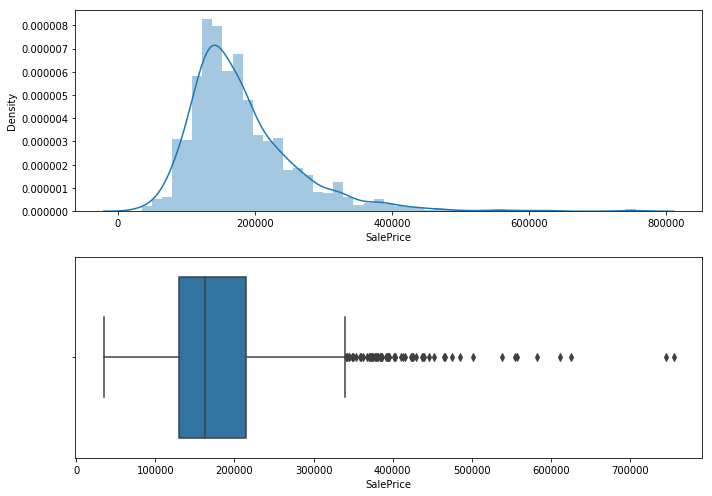

In [16]:
# Visualize the dataset
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(train_data['SalePrice'])

fig.add_subplot(2,1,2)
sns.boxplot(train_data['SalePrice'])
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


<Figure size 720x720 with 0 Axes>

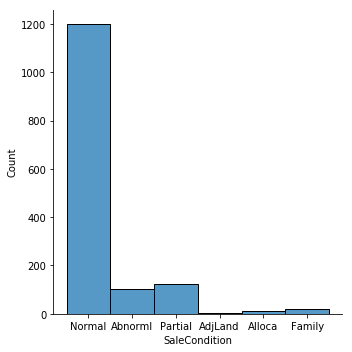

In [17]:
fig = plt.figure(figsize=(10,10))
sns.displot(train_data['SaleCondition'])

In [18]:
train_data = train_data.drop(['Id'], axis=1)

In [19]:
train_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [20]:
train_data.shape

(1460, 80)

In [21]:
# Convert categorical variable into dummy/indicator variable
train_data = pd.get_dummies(train_data, dummy_na=True)
train_data.shape

(1460, 332)

In [22]:
train_data.isnull().sum().sum()

348

In [23]:
train_data=train_data.fillna(train_data.mean())

In [24]:
train_data.isnull().sum().sum()

0

Standardize the dataset

In [25]:
true_prices = train_data['SalePrice'].values
feature = train_data.drop(['SalePrice'], axis=1).values

In [26]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
#numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
#train_data[numeric_features] = train_data[numeric_features].apply(
#lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
#train_data[numeric_features] = train_data[numeric_features].fillna(0)

In [27]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets with 20% test size for convention
X_train, X_test, Y_train, Y_test = train_test_split(feature, true_prices, test_size = 0.2, random_state = 45)

In [28]:
from sklearn.preprocessing import StandardScaler
 
scale= StandardScaler()
X_train = scale.fit_transform(X_train.astype(np.float))
X_test = scale.transform(X_test.astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [29]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rfr = RandomForestRegressor(n_estimators = 1000, random_state = 45)
# Train the model on training data
rfr.fit(X_train, Y_train);

In [30]:
# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 17768.99 degrees.


In [31]:
#compare actual output values with predicted values
y_pred = rfr.predict(X_test)

# evaluate the performance of the algorithm (MAE - MSE - RMSE)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(Y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(Y_test,y_pred))

MAE: 17768.99419863014
MSE: 796715344.6813024
RMSE: 28226.146472398643
VarScore: 0.8789873188356354


In [32]:
df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
df.head(10)

,Actual,Predicted
0,164700,162968.494
1,116000,115686.396
2,266000,312332.600
3,258000,283003.861
4,190000,220648.168
5,142500,139267.201
6,320000,280924.756
7,173000,191221.645
8,159895,180679.263
9,196000,184900.622


In [33]:
r2 = rfr.score(X_test,Y_test)
print("The percentage r2 score for this Random Forest is: ", 100 * round(r2,2), "%")

The percentage r2 score for this Random Forest is:  88.0 %


**Neural Network model**

In [34]:
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(Y_train).reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(np.array(Y_test).reshape(-1, 1), dtype=torch.float32)

In [35]:
loss = nn.MSELoss()
in_features = X_train_tensor.shape[1]

In [44]:
# defining the nerual netowrk with 4 layers. the train data has 331 features after converting categorical variable into dummy/indicator variable
#input layer is determined by the feature shape of training data. 
#First hidden layer has 400 size, second hidden layer has size 380, third hidden layer has size 360, output layer is size 1 which returns the house price prediction
class NeuralNetwork(nn.Module):
        def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.layer1 = nn.Linear(X_train.shape[1], 100) # input: feature.shape[1]=331, output: 400
            self.layer2 = nn.Linear(100, 50)
            self.layer3 = nn.Linear(50,1)
            
# applies a relu function on each layer
        def forward(self, x):
            x  = F.relu(self.layer1(x))
            x  = F.relu(self.layer2(x))
            x  = self.layer3(x)
            return x 

In [45]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [46]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
        print('training loss:', train_ls[epoch], '\ttest loss:', test_ls[epoch])
    return train_ls, test_ls

In [87]:
nn_model = NeuralNetwork()

In [88]:
num_epochs = 30
learning_rate = .01
weight_decay = 0
batch_size = 64

train_loss, valid_loss = train(nn_model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor, 
                               num_epochs=num_epochs, 
                               learning_rate=learning_rate, 
                               weight_decay=weight_decay,
                               batch_size=batch_size)

training loss: 6.1199212074279785 	test loss: 6.11644983291626
training loss: 3.7830212116241455 	test loss: 3.7792928218841553
training loss: 2.3159334659576416 	test loss: 2.2972004413604736
training loss: 1.3212037086486816 	test loss: 1.3088274002075195
training loss: 0.7647545337677002 	test loss: 0.7301937937736511
training loss: 0.5880385041236877 	test loss: 0.5187253355979919
training loss: 0.5435464382171631 	test loss: 0.4437563419342041
training loss: 0.5067530870437622 	test loss: 0.39526790380477905
training loss: 0.4711323380470276 	test loss: 0.36514177918434143
training loss: 0.433765709400177 	test loss: 0.3463623821735382
training loss: 0.40699172019958496 	test loss: 0.33134201169013977
training loss: 0.38357847929000854 	test loss: 0.31875771284103394
training loss: 0.36254382133483887 	test loss: 0.3093448877334595
training loss: 0.34438419342041016 	test loss: 0.3041534423828125
training loss: 0.3270917534828186 	test loss: 0.29849034547805786
training loss: 0.30

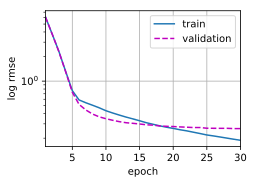

In [89]:
d2l.plot(np.arange(1, num_epochs + 1), [train_loss, valid_loss], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log', legend=['train', 'validation'])

In [90]:
y_pred = nn_model(X_test_tensor).detach().numpy()

In [91]:
from sklearn.metrics import r2_score
R2_sgd = r2_score(Y_test, y_pred)
print("The R2 for the SGD optimizer is: ",R2_sgd)

The R2 for the SGD optimizer is:  0.7908687785752602


In [33]:
feature.shape[1]

331

In [50]:
# defining the nerual netowrk with 4 layers. the train data has 331 features after converting categorical variable into dummy/indicator variable
#input layer is determined by the feature shape of training data. 
#First hidden layer has 400 size, second hidden layer has size 380, third hidden layer has size 360, output layer is size 1 which returns the house price prediction
class NeuralNetwork(nn.Module):
        def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.layer1 = nn.Linear(X_train.shape[1], 400) # input: feature.shape[1]=331, output: 400
            self.layer2 = nn.Linear(400, 370)
            self.layer3 = nn.Linear(370,200)
            self.layer4 = nn.Linear(200,100)
            self.layer5 = nn.Linear(100,50)
            self.layer6 = nn.Linear(50,1)

# applies a relu function on each layer
        def forward(self, x):
            y_pred  = F.relu( self.layer1(x ) )
            y_pred  = F.relu( self.layer2(y_pred ) )
            y_pred  = F.relu( self.layer3(y_pred ) )
            y_pred  = F.relu( self.layer4(y_pred ) )
            y_pred  = F.relu( self.layer5(y_pred ) )
            y_pred  = self.layer6(y_pred)
            return y_pred 

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (layer1): Linear(in_features=331, out_features=400, bias=True)
  (layer2): Linear(in_features=400, out_features=370, bias=True)
  (layer3): Linear(in_features=370, out_features=200, bias=True)
  (layer4): Linear(in_features=200, out_features=100, bias=True)
  (layer5): Linear(in_features=100, out_features=50, bias=True)
  (layer6): Linear(in_features=50, out_features=1, bias=True)
)


*Convert data into a Tensor*

In [40]:
# Convert into tensor
# the data shape of the prediction data will be (***, 1), whereas the data shape of train_price is (***, ). 
#These differences will cause the problem in calculating the loss in training. 
#Therefore, we should reshape the data shape of train_price before converting it into a tensor.
x = torch.tensor(np.array(X_train), dtype=torch.float32)
y = torch.tensor(np.array(Y_train).reshape(-1, 1), dtype=torch.float32)

*Define an Optimizer*

In [41]:
# for the optimizer we gonna use both sgd and adam to see the differences
import torch.optim as optim
sgd_optimizer = optim.SGD(model.parameters(), lr=0.5)
adam_optimizer = optim.Adam(model.parameters(), lr=0.05)

*Define Loss function*

In [42]:
# define our loss function with the Mean Squarred Error
loss_function = nn.MSELoss()

*Train the Model using SGD*

In [ ]:
epochs = 20

for i in range(epochs):
  for 
    # initialize the gradient of model parameters
    sgd_optimizer.zero_grad()

    # calculate the loss
    y_val = model(x)
    loss = loss_function(y_val, y)
    # Backpropagation
    loss.backward()
    
    # Update parameters
    sgd_optimizer.step()
    if (i % 5) == 0:
      print('epoch for the SGD optimizer: {},'.format(i) + 'loss: {:.5f}'.format(loss))

In [45]:
epochs = 20

for i in range(epochs):
    # initialize the gradient of model parameters
    sgd_optimizer.zero_grad()

    # calculate the loss
    y_val = model(x)
    loss = loss_function(y_val, y)
    # Backpropagation
    loss.backward()
    
    # Update parameters
    sgd_optimizer.step()
    if (i % 5) == 0:
      print('epoch for the SGD optimizer: {},'.format(i) + 'loss: {:.5f}'.format(loss))

epoch for the SGD optimizer: 0,loss: nan
epoch for the SGD optimizer: 5,loss: nan
epoch for the SGD optimizer: 10,loss: nan
epoch for the SGD optimizer: 15,loss: nan


*Validation for SGD*

In [46]:
# Prediction
#train_features, test_features, train_price, test_price = train_test_split(feature, true_prices, test_size = 0.2, random_state = 45)
Y_train_pred = model(torch.tensor(X_train, dtype=torch.float))
Y_test_pred = model(torch.tensor(X_test, dtype=torch.float))

# Convert into numpy array
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

*Train the Model using Adam*

In [47]:
epochs = 20

for i in range(epochs):
    # initialize the gradient of model parameters
    adam_optimizer.zero_grad()

    # calculate the loss
    y_val = model(x)
    loss = loss_function(y_val, y)
    # Backpropagation
    loss.backward()
    # Update parameters
    adam_optimizer.step()
    if (i % 5) == 0:
      print('epoch for the Adam optimizer: {},'.format(i) + 'loss: {:.5f}'.format(loss))

epoch for the Adam optimizer: 0,loss: nan
epoch for the Adam optimizer: 5,loss: nan
epoch for the Adam optimizer: 10,loss: nan
epoch for the Adam optimizer: 15,loss: nan


*Validation for Adam*

In [48]:
# Prediction
Y_train_pred_adam = model(torch.tensor(X_train, dtype=torch.float))
Y_test_pred_adam = model(torch.tensor(X_test, dtype=torch.float))

# Convert into numpy array
Y_train_pred_adam = Y_train_pred_adam.detach().numpy()
Y_test_pred_adam = Y_test_pred_adam.detach().numpy()

*Accuracy: R2*

In [49]:
from sklearn.metrics import r2_score
R2_sgd = r2_score(Y_test, Y_test_pred)
print("The R2 for the SGD optimizer is: ",R2_sgd)

ValueError: ignored

In [ ]:
from sklearn.metrics import r2_score
R2_sgd = r2_score(Y_test, Y_test_pred)
print("The R2 for the SGD optimizer is: ",R2_sgd)

ValueError: ignored

In [ ]:
R2_adam = r2_score(Y_test_pred_adam, Y_test_pred_adam)
print("The R2 for the Adam optimizer is: ",R2_adam)